### Emma Klemets, 260775167   
Analysis and results for **Q4 & Q5** are in this notebook, the actual MCMC script is in MCMC_run.py, with saved runs files of chain, chi-squared and acceptance rate in files named similar to: "MCMCrun_chains.txt", "MCMCrun_chi.txt", "MCMCrun_AR.txt".   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wmap_camb_example

import corner

In [2]:
variable_names = ['H_0', 'w_b h^2', 'w_c h^2', 'tau', 'A_s', 'slope']

#prints out values, std errors and 95% confidence interval for given chain
def printVals(chain, burnIn):
    pars_new=np.mean(chain[burnIn:,:], axis=0)
    std_new=np.std(chain[burnIn:,:], axis=0)

    sortedChains = np.sort(np.transpose(chain[burnIn:, :]), axis=1)

    for i, e in enumerate(pars_new):
        
        Min = sortedChains[i][int(0.025*len( sortedChains[0]))]
        Max = sortedChains[i][int(0.975*len( sortedChains[0]))]
        print("{}: {:.4}, std: {:.4}, 95% interval = [{:.4}, {:.4}]".format(variable_names[i], \
                                        e, std_new[i], Min, Max))
        

### 4) 
*Now write a Markov-chain Monte Carlo where you fit the basic 6 parameters, including τ. However, note that we know the optical depth can’t be negative, so you should reject any steps that try to sample a negative τ. What are your parameter limits now? Please also present an argument as to why you think your chains are converged.*

In [3]:
#loading MCMC saved chains

#10000 steps
chain1 = np.loadtxt("MCMCrun_chains5.txt")
chi1 = np.loadtxt("MCMCrun_chi5.txt")
AR1 = np.loadtxt("MCMCrun_AR5.txt")

H_0: 85.13, std: 2.946, 95% interval = [79.72, 90.91]
w_b h^2: 0.0264, std: 0.0007029, 95% interval = [0.02492, 0.02768]
w_c h^2: 0.09096, std: 0.00432, 95% interval = [0.08256, 0.09878]
tau: 0.3566, std: 0.01643, 95% interval = [0.3277, 0.3906]
A_s: 3.628e-09, std: 1.091e-10, 95% interval = [3.427e-09, 3.873e-09]
slope: 1.102, std: 0.01749, 95% interval = [1.066, 1.135]

Ave acceptance rate:  0.5405796572310222


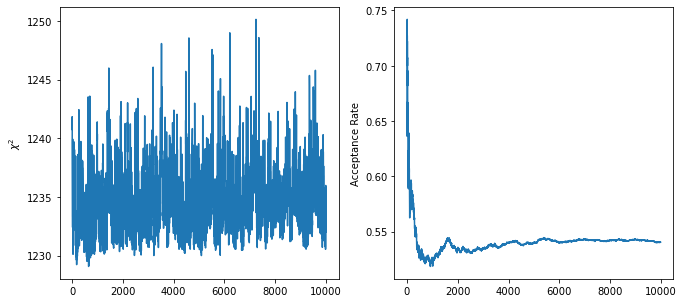

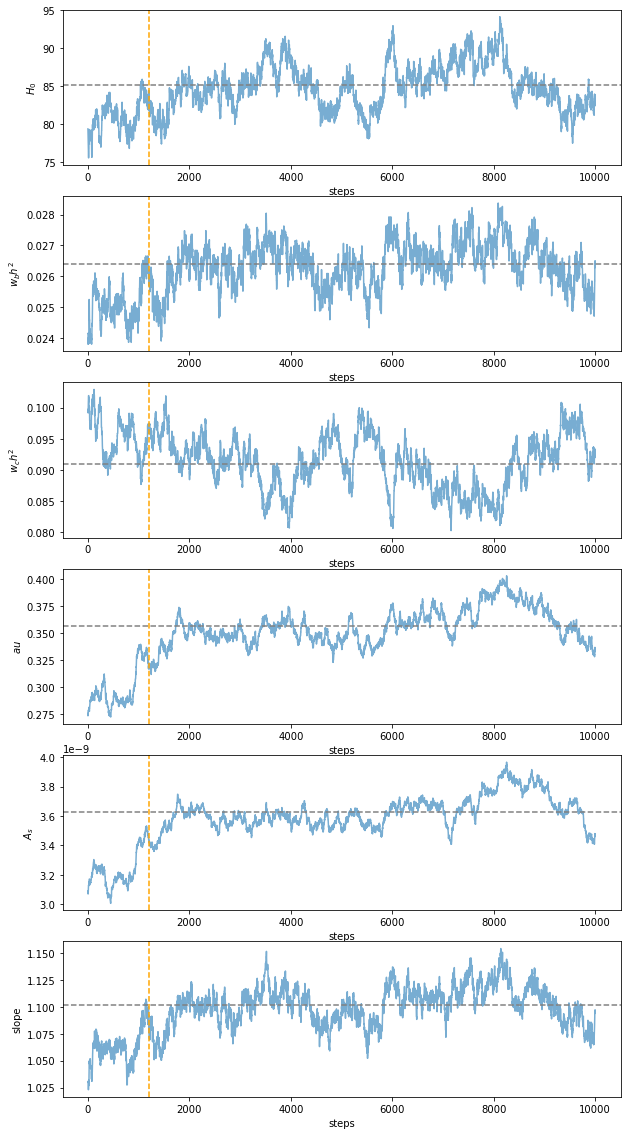

In [4]:
#get means and stds of chains
burnIn = 1200

pars_new=np.mean(chain1[burnIn:,:], axis=0)
std_new=np.std(chain1[burnIn:,:], axis=0)
# print("Resulting values: ", pars_new, "with std", std_new )

printVals(chain1, burnIn)
print("\nAve acceptance rate: ", np.mean(AR1))

#transpose chains for ease
paths = np.transpose(chain1)

#plot chi^2 and acceptance rate
fig, ax = plt.subplots(1, 2, figsize=(11,5))
ax[0].plot(chi1[:])
ax[0].set_ylabel("$\chi^2$")

ax[1].plot(AR1[20:])
ax[1].set_ylabel("Acceptance Rate")

plt.show()

#plot all the chains
variables = ['$H_0$', '$w_bh^2$', '$w_ch^2$', '$\tau$', '$A_s$', 'slope']

fig, ax = plt.subplots(6, 1, figsize=(10,20))
axs = ax.flatten()

for i, vchain in enumerate(paths):
    axs[i].plot(vchain[:], alpha=0.6)
#     axs[i].set_title(variables[i])
    axs[i].axhline(pars_new[i], color='grey', ls="--", label="mean")
    axs[i].axvline(burnIn, color='orange', ls="--", label="burn in")

    axs[i].set_xlabel('steps')
    axs[i].set_ylabel(variables[i])

plt.show()

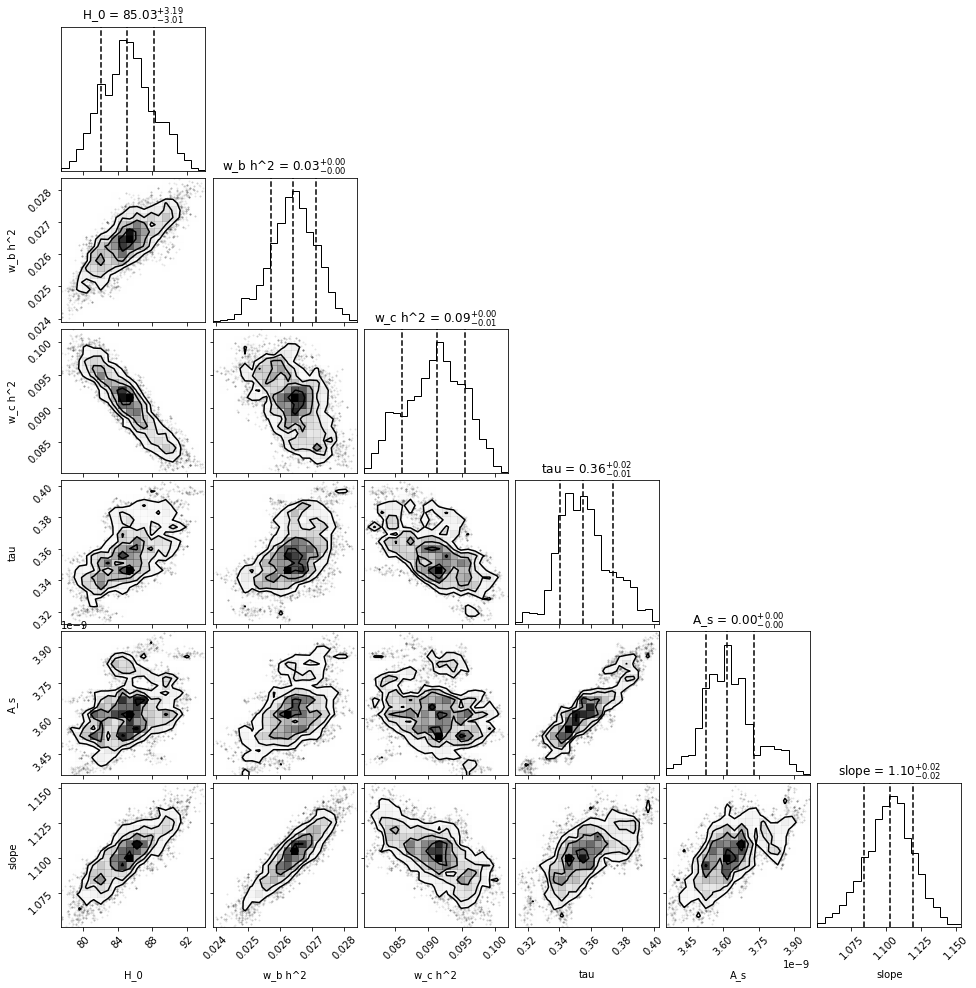

In [5]:
#corner plot to look at all the parameter corelation as histograms
figure = corner.corner(chain1[burnIn:,:], labels=variable_names, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})

*Please also present an argument as to why you think your chains are converged*

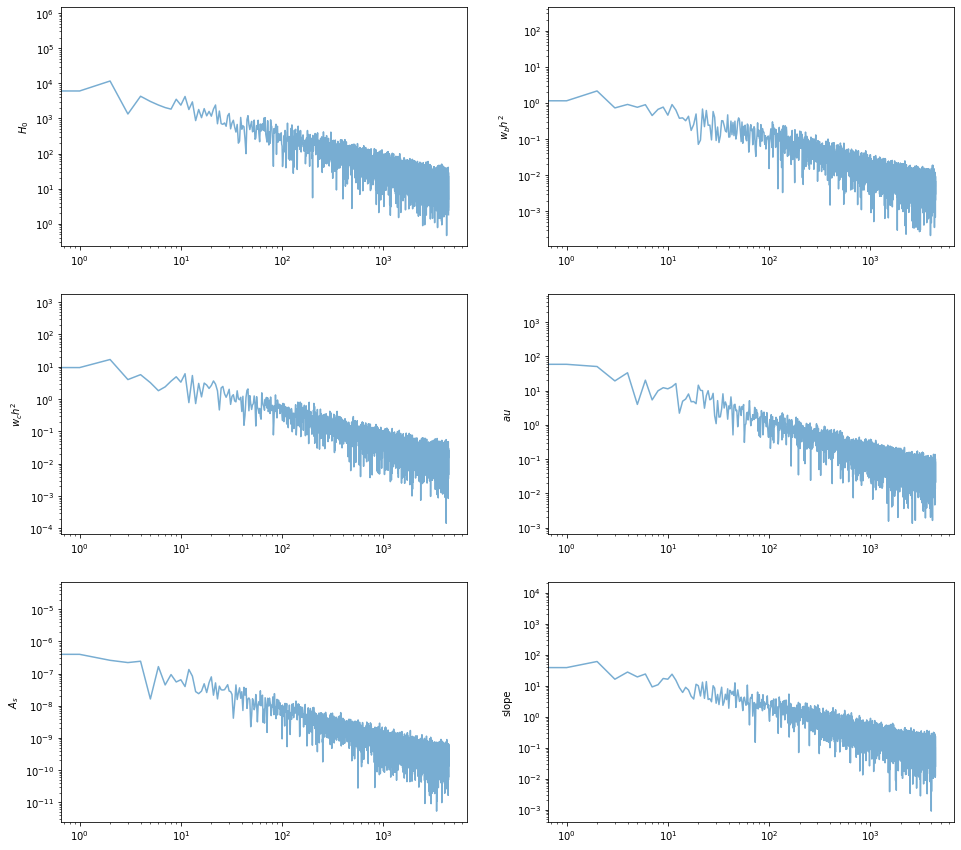

In [6]:
#fourier transform to power spectrum to look at convergence
fig, ax = plt.subplots(3, 2, figsize=(16,15))
axs = ax.flatten()

paths = np.transpose(chain1[burnIn:,:])

for i, vchain in enumerate(paths):
    
    axs[i].loglog(abs(np.fft.rfft(vchain)), alpha=0.6)
    axs[i].set_ylabel(variables[i])

plt.show()

In [16]:
#set this depending on where the break is seens
xbreak = 5e0/len(abs(np.fft.rfft(paths[0][100:])))
# print(xbreak, len(chain1))


#multiply by the total number of samples
print("Aprox number of indep samples: ", xbreak*len(chain1))

Aprox number of indep samples:  11.491611123879567


Looking at the square of the power spectrum, we would like to see a flat part for low frequencies and then a 'knee' where the incline increases alot. The x value there would indicate the number of independant samples. With a reasonable number of independant samples, this would imply convergence. I don't think I really have convergence, there isn't really a flat part of the power spectrum at low frequencies, and just looking at the paths of the walkers for each chain, there is still quite a bit of over all movement. I think these chains need to run longer to get an answer with more certainty.

### 5) 
The Planck satellite has independently measured the CMB sky, and finds
that the optical depth is 0.0544 ± 0.0073. Run a chain where you add this in as a prior on the value of τ. What are your new parameter values/constraints?    
You can also take your chain from part 4) and importance sample it (weighting by the prior) with the Planck τ prior. How to those results compare to the full chain results?   

### Importance Sampling

In [17]:
# old likelihood, using chi squared
oldLike = np.exp(-0.5*(chi1[burnIn:]))

#taking the error on the Planck value as gaussian
ga = np.random.normal(loc=0.0544, scale=0.0073, size=len(oldLike))

#mutiply to get new likelihood
newLike =  oldLike*ga

In [9]:
#weighting means and std by new likelihood to get new results
smallerTau_means = []
smallerTau_scat = []
smallerTau_errs = []

for j in range(paths.shape[0]):
    smallerTau_means.append( np.sum(newLike*paths[j])/np.sum(newLike) )
    
    #subtract the mean from the orginal chain so we can calculate the
    #standard deviation
    smallerTau_scat.append(paths[j]-smallerTau_means[-1])
    smallerTau_errs.append(np.sqrt(np.sum(smallerTau_scat[-1]**2*newLike)/np.sum(newLike)))

In [10]:
print("Parameters and constraints from importance sampling:")
for i, e in enumerate(smallerTau_means):
    print("{}: {:.4}, std: {:.4}".format(variable_names[i], e, smallerTau_errs[i]))

Parameters and constraints from importance sampling:
H_0: 84.98, std: 2.461
w_b h^2: 0.02637, std: 0.0005641
w_c h^2: 0.09117, std: 0.003595
tau: 0.3544, std: 0.01592
A_s: 3.614e-09, std: 1.045e-10
slope: 1.101, std: 0.01467


*How to those results compare to the full chain results?*   
IS: tau: 0.3544, std: 0.01592   
MCMC: tau: 0.05465, std: 0.006051   


These values really aren't that close to the ones below, and neigher of them are actually within the new limits for tau. Although the MCMC fit looks better with this prior enforced, the resulting value of tau is very small (prehaps I put this prior in my code wrong), and I would put more confidence in the importance sampled results.

### Rerun MCMC with smaller Tau prior

In [11]:
#10000 steps
chain2 = np.loadtxt("MCMCrun_chains_tau2.txt")
chi2 = np.loadtxt("MCMCrun_chi_tau2.txt")
AR2 = np.loadtxt("MCMCrun_AR_tau2.txt")


H_0: 70.24, std: 2.024, 95% interval = [66.37, 74.14]
w_b h^2: 0.02253, std: 0.0005454, 95% interval = [0.02147, 0.02362]
w_c h^2: 0.1117, std: 0.004088, 95% interval = [0.104, 0.1198]
tau: 0.05465, std: 0.006051, 95% interval = [0.04271, 0.06667]
A_s: 2.047e-09, std: 3.739e-11, 95% interval = [1.977e-09, 2.116e-09]
slope: 0.9725, std: 0.01336, 95% interval = [0.9464, 0.9991]

Ave acceptance rate:  0.4836356029254641


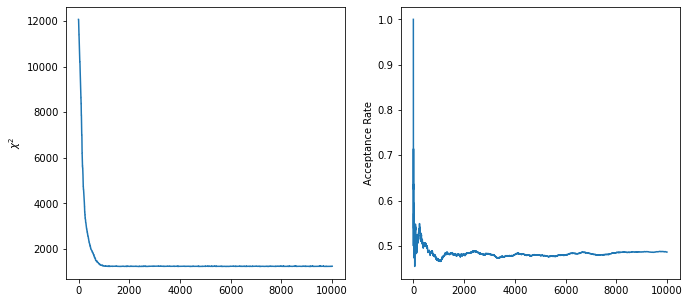

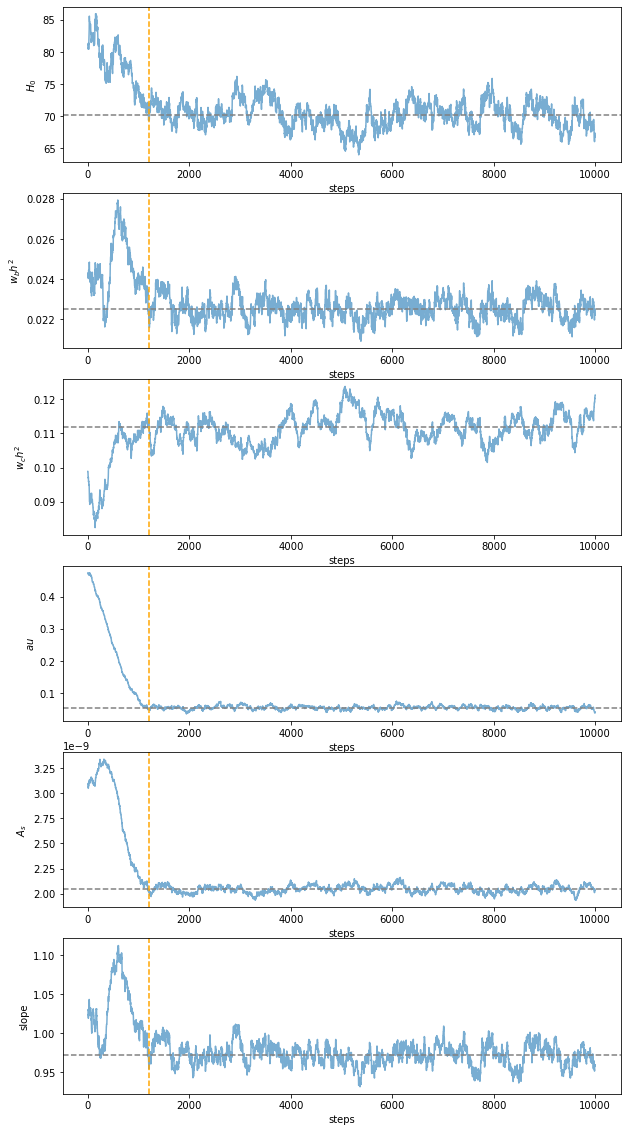

In [12]:
burnIn2 = 1200
pars_new=np.mean(chain2[burnIn2:,:], axis=0)
std_new=np.std(chain2[burnIn2:,:], axis=0)
# print("Resulting values: ", pars_new, "with std", std_new )

printVals(chain2, burnIn2)
print("\nAve acceptance rate: ", np.mean(AR2))

paths2 = np.transpose(chain2)

fig, ax = plt.subplots(1, 2, figsize=(11,5))
ax[0].plot(chi2[:])
ax[0].set_ylabel("$\chi^2$")

ax[1].plot(AR2[:])
ax[1].set_ylabel("Acceptance Rate")

plt.show()

variables = ['$H_0$', '$w_bh^2$', '$w_ch^2$', '$\tau$', '$A_s$', 'slope']

fig, ax = plt.subplots(6, 1, figsize=(10,20))
axs = ax.flatten()

#plotting chains, with means and burn in marked
for i, vchain in enumerate(paths2):
    axs[i].plot(vchain[:], alpha=0.6)
#     axs[i].set_title(variables[i])
    axs[i].axhline(pars_new[i], color='grey', ls="--", label="std")
    axs[i].axvline(burnIn2, color='orange', ls="--", label="burn in")
    axs[i].set_xlabel('steps')
    axs[i].set_ylabel(variables[i])

plt.show()

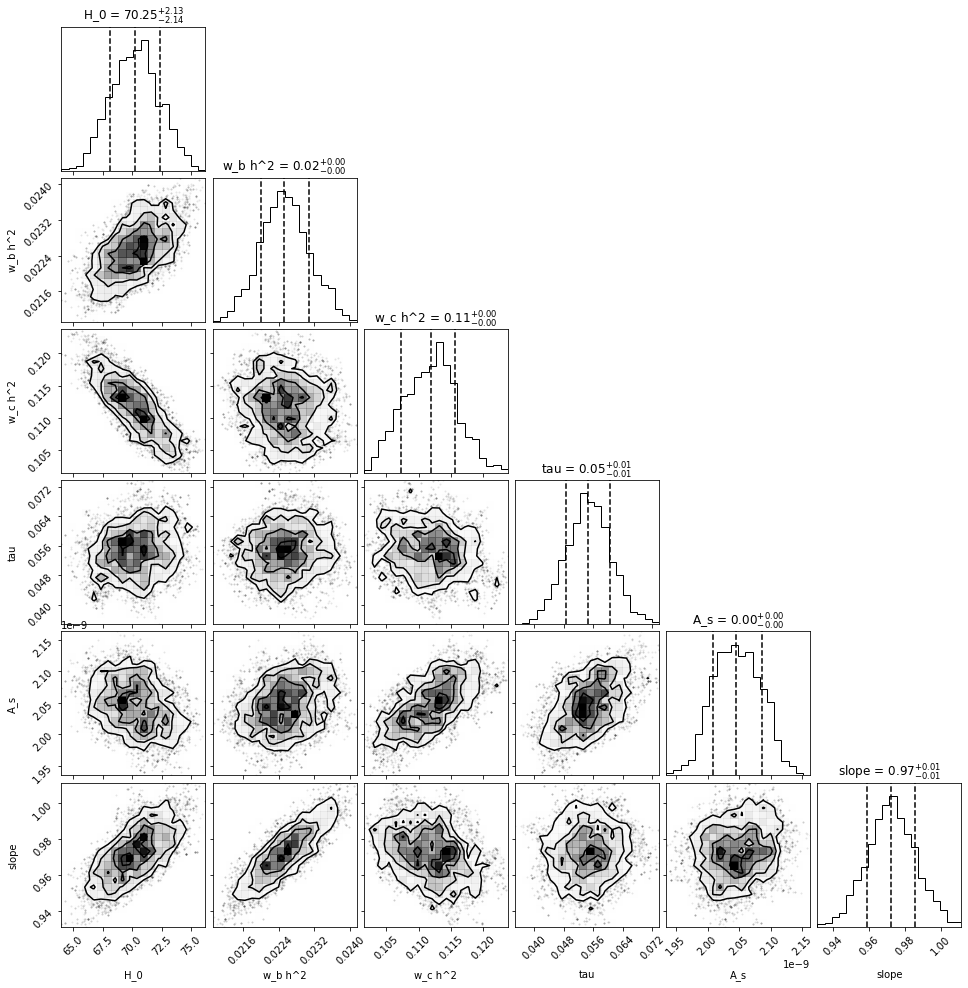

In [13]:
figure = corner.corner(chain2[burnIn2:,:], labels=variable_names, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})

#much nicer histograms than for first chains

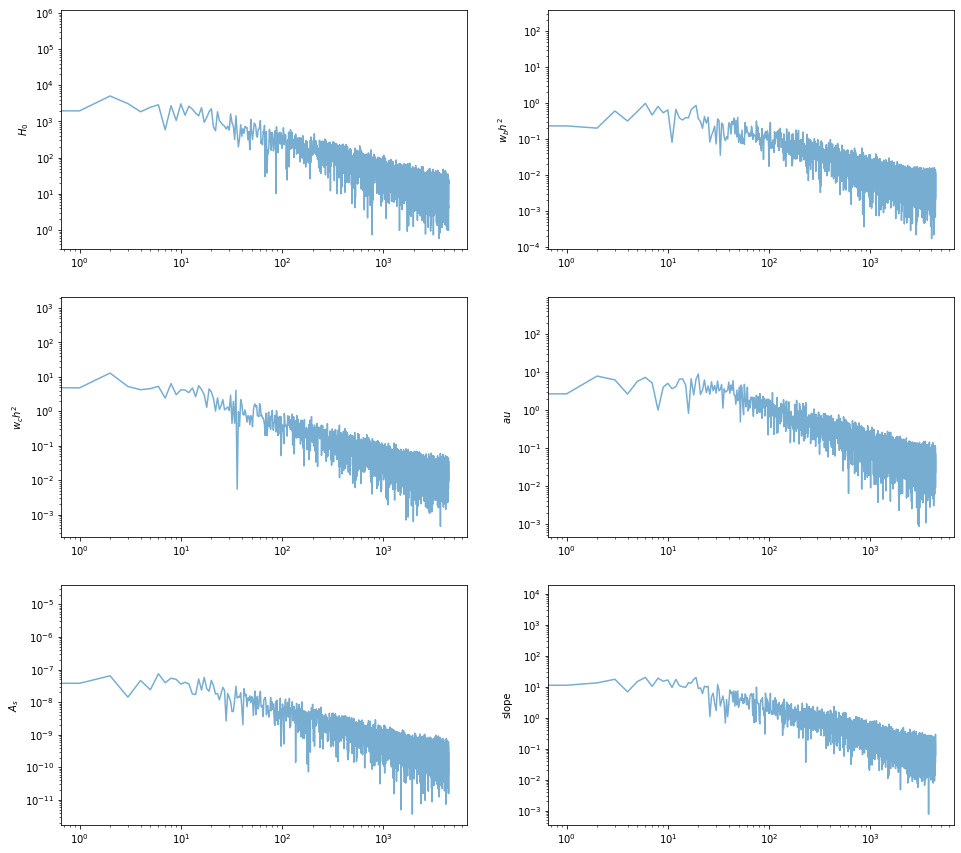

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(16,15))
axs = ax.flatten()

paths = np.transpose(chain2[burnIn2:,:])

for i, vchain in enumerate(paths):
    
    axs[i].loglog(abs(np.fft.rfft(vchain)), alpha=0.6, )
    axs[i].set_ylabel(variables[i])

plt.show()

In [15]:
#set this depending on where the break is seen
xbreak = 1.4e1/len(abs(np.fft.rfft(paths2[0])))

#multiply by the total number of samples
print("Aprox number of indep samples: ", xbreak*len(chain1))

Aprox number of indep samples:  27.994401119776047


Here we see a bit of flattening until about x~14, so this chain is starting to converge, but this only gives about 27 independant samples, which doesn't seem like enough for a proper fit. I would run this MCMC longer to get more samples before trusting the result.